In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt
class MLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=10, output_size=3):
        super(MLP, self).__init__()
        self.map = []
        self.activation = {}
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.map.append(input_size)
        self.relu = nn.ReLU()
        self.map.append(hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        self.activation['fc1'] = x.reshape(x.shape[0], -1)
        out = self.fc1(x)
        out = self.relu(out)
        self.activation['fc2'] = out.reshape(out.shape[0], -1)
        out = self.fc2(out)
        return out

# create a toy dataset consist of thress guassian distributions

/home/huichen/Data/miniconda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ToyDataset(torch.utils.data.Dataset):
    def __init__(self, data, label):
        self.data = data
        self.targets = label
        self.len = data.shape[0]
    def __getitem__(self, index):
        return self.data[index], self.targets[index]
    def __len__(self):
        return self.len

In [3]:
def test_by_class(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    y_list = []
    pred_y_list = []
    with torch.no_grad():
        for batch, (x, y) in enumerate(test_loader):
            pred_y = model(x)
            predicted = torch.argmax(pred_y.data, 1)
            y_list.append(y)
            pred_y_list.append(predicted)

        y_list = torch.cat(y_list)
        pred_y_list = torch.cat(pred_y_list)
        # calculate accuracy for each class
        for c in torch.unique(y_list):
            class_indices = torch.where(y_list == c)[0]
            correct = torch.sum(pred_y_list[class_indices] == y_list[class_indices]).item()
            total = len(class_indices)
            acc = correct / total
            print(f'{acc:.3f}, ', end='')
        print('\n')

def update_GPM(mat_list, threshold, feature_list=[],):
    print(f'Threshold:{threshold}') 
    if not feature_list:
        # After First Task 
        for i in range(len(mat_list)):
            activation = mat_list[i]
            U,S,Vh = np.linalg.svd(activation, full_matrices=False)
            # criteria (Eq-5)
            sval_total = (S**2).sum()
            sval_ratio = (S**2)/sval_total
            r = np.sum(np.cumsum(sval_ratio)<threshold[i]) #+1  
            feature_list.append(U[:,0:r])
    else:
        for i in range(len(mat_list)):
            activation = mat_list[i]
            U1,S1,Vh1=np.linalg.svd(activation, full_matrices=False)
            sval_total = (S1**2).sum()
            # Projected Representation (Eq-8)
            act_hat = activation - np.dot(np.dot(feature_list[i],feature_list[i].transpose()),activation)
            U,S,Vh = np.linalg.svd(act_hat, full_matrices=False)
            # criteria (Eq-9)
            sval_hat = (S**2).sum()
            sval_ratio = (S**2)/sval_total    
            accumulated_sval = (sval_total-sval_hat)/sval_total
            r = 0
            for ii in range (sval_ratio.shape[0]):
                if accumulated_sval < threshold[i]:
                    accumulated_sval += sval_ratio[ii]
                    r += 1
                else:
                    break
            if r == 0:
                print('Skip Updating GPM for layer: {}'.format(i+1)) 
                continue
            # update GPM U矩阵的每一列都是一个basis，彼此之间互相垂直，是orthnormal的
            Ui=np.hstack((feature_list[i],U[:,0:r]))  # 把新的basis添加到feature_list中，[A B] of size 48*11, A of size 48*7 是之前的basis，B of size48*4 是新的basis
            if Ui.shape[1] > Ui.shape[0] :
                feature_list[i]=Ui[:,0:Ui.shape[0]]
            else:
                feature_list[i]=Ui
    
    print('-'*40)
    print('Gradient Constraints Summary')
    print('-'*40)
    for i in range(len(feature_list)):
        print('Layer {} : {}/{}'.format(i+1,feature_list[i].shape[1], feature_list[i].shape[0]))
    print('-'*40)
    return feature_list  

def merge_subspace(per_class_basis_dict, unlearn_class):
    new_basis = []
    proj_mat = []
    num_layer = len(list(per_class_basis_dict.items())[0][1])
    for layer in range(num_layer):
        concat_layer_basis = []
        for cls_id in per_class_basis_dict.keys():
            basis_list = per_class_basis_dict[cls_id]
            if cls_id in unlearn_class:
                continue
            else:
                concat_layer_basis.append(basis_list[layer])

        U,S,Vh=np.linalg.svd(np.concatenate(concat_layer_basis, axis=1), full_matrices=False)
        sval_total = (S**2).sum()
        sval_ratio = (S**2)/sval_total
        r = np.sum(np.cumsum(sval_ratio)<0.98) #+1  
        new_layer_basis = U[:, :r]
        new_basis.append(new_layer_basis)
        proj_mat.append(torch.Tensor(np.dot(new_layer_basis, new_layer_basis.transpose())).cuda())
    
    return new_basis, proj_mat

In [4]:
reproduce_dict = torch.load('toy_reproduce_dict_2023-11-27.pt')

train_X = reproduce_dict['data']['train_X']
train_Y = reproduce_dict['data']['train_Y']
test_X = reproduce_dict['data']['test_X']
test_Y = reproduce_dict['data']['test_Y']

model_4 = MLP(output_size=4)
model_4.load_state_dict(reproduce_dict['model'])

model_3 = MLP(output_size=4)
model_3.load_state_dict(reproduce_dict['model_r'])
proj_mat = reproduce_dict['proj_mat']
model_sf = MLP(output_size=4)
model_sf.load_state_dict(reproduce_dict['model_u'])



<All keys matched successfully>

In [5]:
train_dataset = ToyDataset(train_X, train_Y)
test_dataset = ToyDataset(test_X, test_Y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=True)

In [7]:
data_1 = train_X[train_Y==0]
data_2 = train_X[train_Y==1]
data_3 = train_X[train_Y==2]
data_4 = train_X[train_Y==3]

laybel_1 = torch.zeros(data_1.shape[0])
laybel_2 = torch.ones(data_2.shape[0])
laybel_3 = torch.ones(data_3.shape[0])*2
laybel_4 = torch.ones(data_4.shape[0])*3

(-3.0, 3.0)

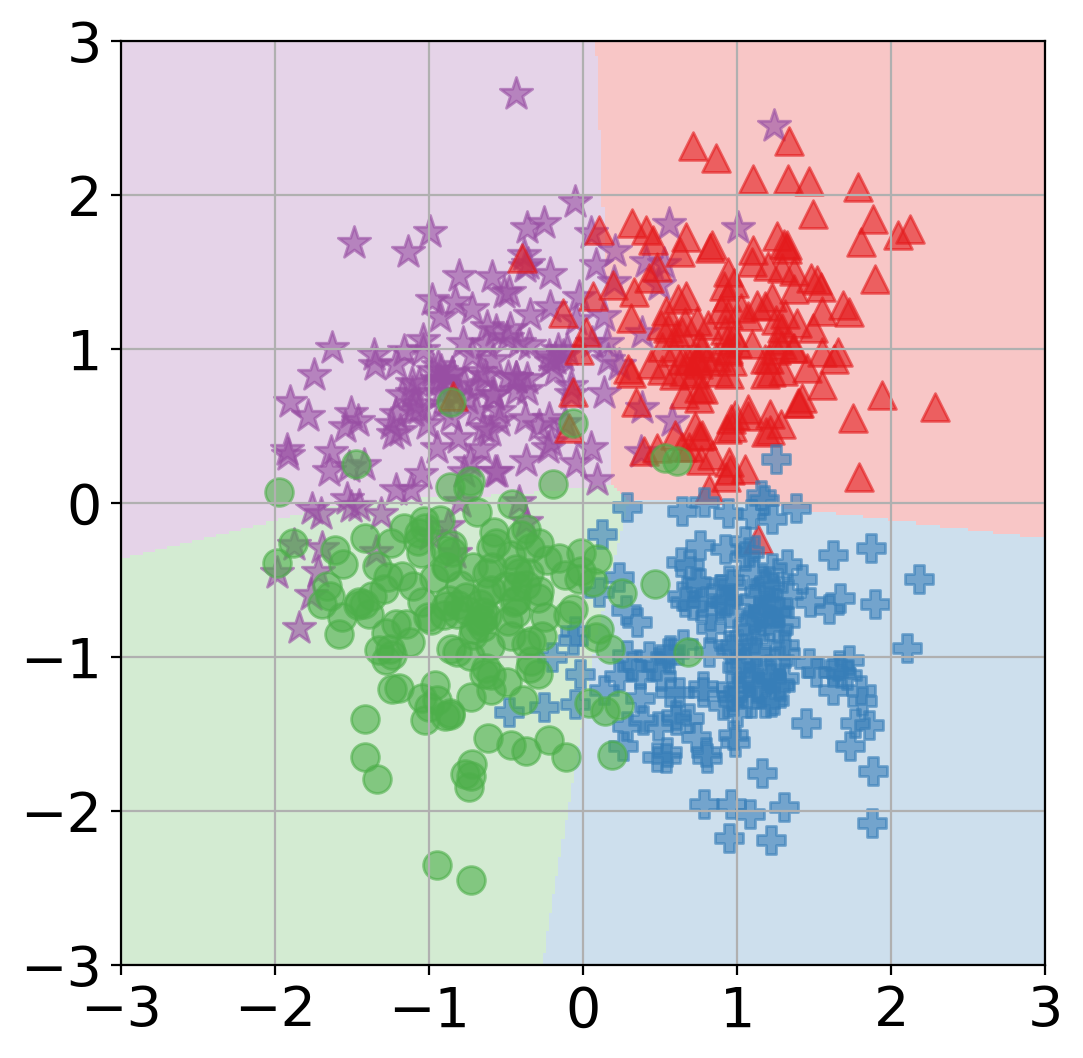

In [8]:
from matplotlib.colors import ListedColormap

set1_cmap = ListedColormap(plt.colormaps['Set1'].colors)
step = .02
T = 1 #softmax temperature
x1_min, x1_max = -3, 3 
x2_min, x2_max = -3, 3
x1_range, x2_range = np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step)
xx1, xx2 = np.meshgrid(x1_range, x2_range) # # (500, 400) for both, i.e (x2,x1) as (height,width) as wanted
xx1e, xx2e = np.expand_dims(xx1, -1), np.expand_dims(xx2, -1) # (500, 400, 1) for both
xx = np.concatenate([xx1e, xx2e], axis=-1) ## (500, 400, 2)

xxflat = xx.reshape((-1, 2)) #(200000, 2)
Y_teacher = torch.softmax(model_4(torch.from_numpy(xxflat).float())/T, dim=1).detach().numpy() #(200000, 3)
image_teacher = Y_teacher.reshape(x2_range.shape[0], x1_range.shape[0], -1) #(500, 400, 3)

class_preds = np.argmax(Y_teacher, axis=1)
colors = np.array([list(set1_cmap.colors[c]) for c in class_preds])

image_teacher = colors.reshape(x2_range.shape[0], x1_range.shape[0], 3)

fig, ax = plt.subplots(1, 1, figsize=(6,6), dpi=200)
interval=5
ax.imshow(image_teacher, extent=[x1_min, x1_max, x2_min, x2_max], alpha=0.25, origin='lower')
ax.scatter(data_4[::interval, 0], data_4[::interval, 1], alpha=0.6, color=set1_cmap.colors[3], marker='*', s=150)
ax.scatter(data_1[::interval, 0], data_1[::interval, 1], alpha=0.6, color=set1_cmap.colors[0], marker='^', s=100)
ax.scatter(data_2[::interval, 0], data_2[::interval, 1], alpha=0.6, color=set1_cmap.colors[1], marker='P', s=100)
ax.scatter(data_3[::interval, 0], data_3[::interval, 1], alpha=0.6, color=set1_cmap.colors[2], marker='o', s=100)
ax.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

In [9]:
unlearn_class = [3]
remain_class = [0, 1, 2]
train_targets_list = np.array(train_dataset.targets)
remain_cls_indices = np.where(~np.isin(train_targets_list, unlearn_class[0]))[0]
cls_sampler = torch.utils.data.SubsetRandomSampler(remain_cls_indices)
remain_loader = torch.utils.data.DataLoader(train_dataset, 
                                            batch_size=100, 
                                            sampler=cls_sampler)

model_3 = MLP(output_size=4)
optim = torch.optim.Adam(model_3.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

for ep in range(10):
    losses = 0
    corrects = 0
    total = 0
    for x, y in remain_loader:
        y_hat = model_3(x)
        loss = loss_fn(y_hat, y.long())
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses += loss.item()
        corrects += (torch.argmax(y_hat, dim=1) == y).sum().item()
        total += 1
    print(f'[train][ep]loss: {losses/total:.3f}, acc: {corrects/total:.3f}')

test_by_class(model_3, test_loader)

[train][ep]loss: 1.056, acc: 64.875
[train][ep]loss: 0.418, acc: 93.292
[train][ep]loss: 0.193, acc: 94.458
[train][ep]loss: 0.148, acc: 94.667
[train][ep]loss: 0.136, acc: 94.667
[train][ep]loss: 0.132, acc: 94.750
[train][ep]loss: 0.129, acc: 94.750
[train][ep]loss: 0.129, acc: 94.625
[train][ep]loss: 0.128, acc: 94.875
[train][ep]loss: 0.127, acc: 94.875
0.977, 0.943, 0.934, 0.000, 



(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3')])

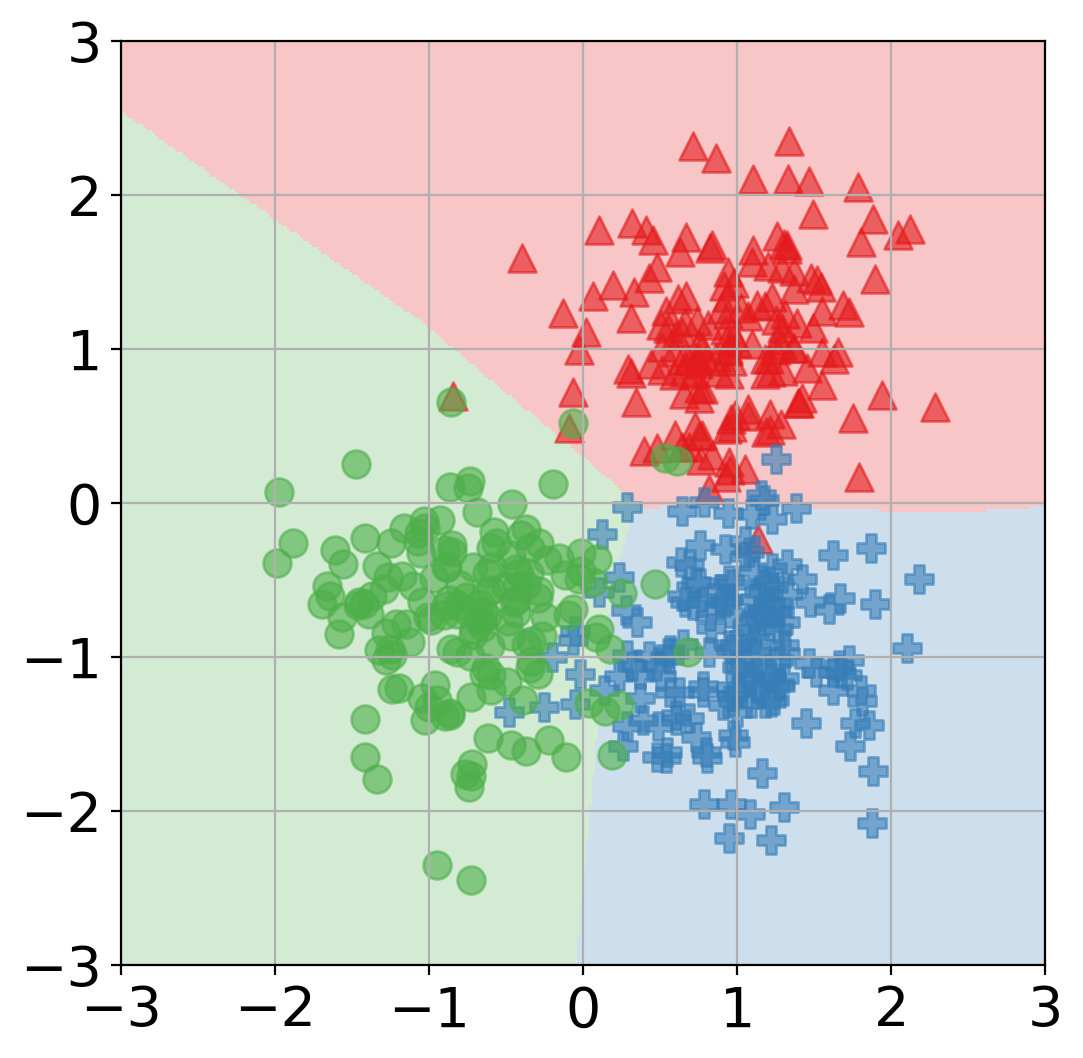

In [21]:
step = .02
T = 1 #softmax temperature
x1_min, x1_max = -3, 3 
x2_min, x2_max = -3, 3
x1_range, x2_range = np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step)
xx1, xx2 = np.meshgrid(x1_range, x2_range) # # (500, 400) for both, i.e (x2,x1) as (height,width) as wanted
xx1e, xx2e = np.expand_dims(xx1, -1), np.expand_dims(xx2, -1) # (500, 400, 1) for both
xx = np.concatenate([xx1e, xx2e], axis=-1) ## (500, 400, 2)
xxflat = xx.reshape((-1, 2)) #(200000, 2)

Y_teacher = torch.softmax(model_3(torch.from_numpy(xxflat).float())/T, dim=1).detach().numpy() #(200000, 3)
image_teacher = Y_teacher.reshape(x2_range.shape[0], x1_range.shape[0], -1) #(500, 400, 3)

class_preds = np.argmax(Y_teacher, axis=1)
colors = np.array([list(set1_cmap.colors[c]) for c in class_preds])
image_teacher = colors.reshape(x2_range.shape[0], x1_range.shape[0], 3)

fig, ax = plt.subplots(figsize=(6,6), dpi=200)
interval=5
ax.imshow(image_teacher, extent=[x1_min, x1_max, x2_min, x2_max], alpha=0.25, origin='lower')
ax.scatter(data_1[::interval, 0], data_1[::interval, 1], alpha=0.6, color=set1_cmap.colors[0], marker='^', s=100)
ax.scatter(data_2[::interval, 0], data_2[::interval, 1], alpha=0.6, color=set1_cmap.colors[1], marker='P', s=100)
ax.scatter(data_3[::interval, 0], data_3[::interval, 1], alpha=0.6, color=set1_cmap.colors[2], marker='o', s=100)
# ax.scatter(data_4[::interval, 0], data_4[::interval, 1], alpha=0.16, color=set1_cmap.colors[3], marker='^', s=50)
ax.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [64]:
# Randomly sample unlearn
import copy
import numpy as np
X_f = data_4
Y_f = laybel_4
dataset_f = ToyDataset(X_f, Y_f)

train_size_f = int(0.8 * len(dataset_f))
test_size_f = len(dataset_f) - train_size_f
# split the dataset into train and test sets
train_dataset_f, test_dataset_f = torch.utils.data.random_split(dataset_f, [train_size_f, test_size_f] )

train_loader_f = torch.utils.data.DataLoader(train_dataset_f, batch_size=100, shuffle=True)
test_loader_f = torch.utils.data.DataLoader(test_dataset_f, batch_size=100, shuffle=True)

X = torch.cat((data_1, data_2, data_3, data_4), 0)
Y = torch.cat((laybel_1, laybel_2, laybel_3, laybel_4), 0)
dataset_4 = ToyDataset(X, Y)

train_size = int(0.8 * len(dataset_4))
test_size = len(dataset_4) - train_size
# split the dataset into train and test sets
train_dataset_4, test_dataset_4 = torch.utils.data.random_split(dataset_4, [train_size, test_size] )
train_loader_4 = torch.utils.data.DataLoader(train_dataset_4, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset_4, batch_size=256, shuffle=True)

model_f = MLP(output_size=4)
model_f.load_state_dict(model_4.state_dict())
optim = torch.optim.SGD(model_f.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

remain_class =[0, 1, 2,]
print(f'original model test acc')
test_by_class(model_f, test_loader)

for ep in range(20):
    x_lst = []
    y_lst = []
    y_hat_lst = []
    losses = 0
    corrects = 0
    total = 0
    for x, y in train_loader_f:
        output = model_f(x)
        y = torch.from_numpy(np.random.choice(remain_class, size=x.shape[0]))
        y_hat = torch.argmax(output, dim=1)
        loss = loss_fn(output, y.long())
        optim.zero_grad()
        loss.backward()
        optim.step()
        losses += loss.item()
        corrects += (y_hat == y).sum().item()
        total += 1
        x_lst.append(x)
        y_lst.append(y)
        y_hat_lst.append(y_hat)

    test_by_class(model_f, test_loader)

x_lst = torch.cat(x_lst)
y_lst = torch.cat(y_lst)
y_hat_lst = torch.cat(y_hat_lst)

original model test acc
0.934, 0.951, 0.860, 0.789, 

0.934, 0.951, 0.893, 0.667, 

0.940, 0.957, 0.899, 0.537, 

0.940, 0.963, 0.893, 0.469, 

0.934, 0.963, 0.904, 0.367, 

0.927, 0.976, 0.904, 0.327, 

0.934, 0.982, 0.893, 0.238, 

0.914, 0.988, 0.860, 0.177, 

0.914, 0.988, 0.843, 0.122, 

0.914, 0.994, 0.809, 0.095, 

0.907, 0.994, 0.798, 0.061, 

0.887, 0.994, 0.770, 0.034, 

0.881, 0.994, 0.713, 0.000, 

0.854, 0.994, 0.680, 0.000, 

0.848, 1.000, 0.652, 0.000, 

0.828, 1.000, 0.629, 0.000, 

0.815, 1.000, 0.607, 0.000, 

0.801, 1.000, 0.567, 0.000, 

0.788, 1.000, 0.528, 0.000, 

0.781, 1.000, 0.500, 0.000, 

0.775, 1.000, 0.478, 0.000, 



(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3')])

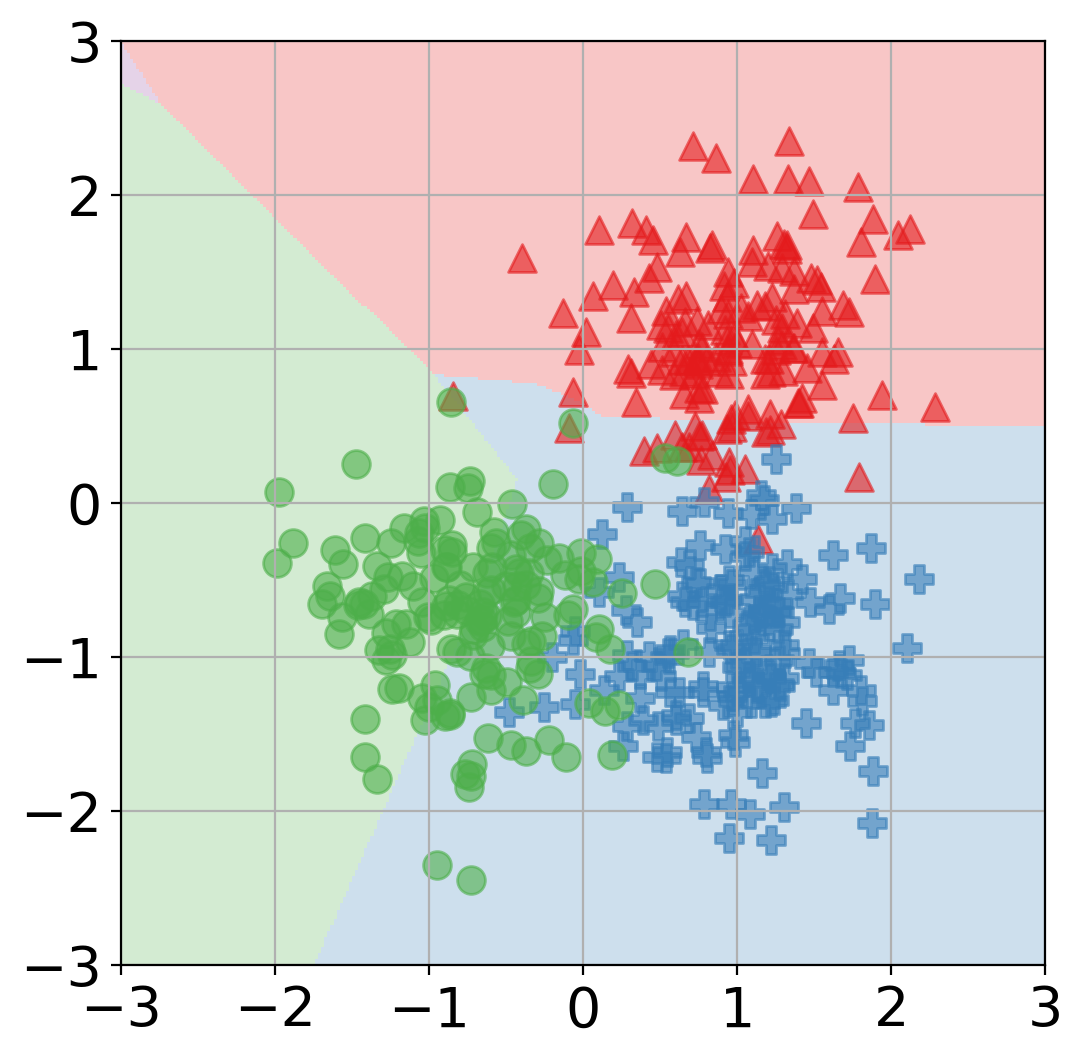

In [65]:
step = .02
T = 1 #softmax temperature
x1_min, x1_max = -3, 3 
x2_min, x2_max = -3, 3
x1_range, x2_range = np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step)
xx1, xx2 = np.meshgrid(x1_range, x2_range) # # (500, 400) for both, i.e (x2,x1) as (height,width) as wanted
xx1e, xx2e = np.expand_dims(xx1, -1), np.expand_dims(xx2, -1) # (500, 400, 1) for both
xx = np.concatenate([xx1e, xx2e], axis=-1) ## (500, 400, 2)
xxflat = xx.reshape((-1, 2)) #(200000, 2)

Y_teacher = torch.softmax(model_f(torch.from_numpy(xxflat).float())/T, dim=1).detach().numpy() #(200000, 3)
image_teacher = Y_teacher.reshape(x2_range.shape[0], x1_range.shape[0], -1) #(500, 400, 3)

class_preds = np.argmax(Y_teacher, axis=1)
colors = np.array([list(set1_cmap.colors[c]) for c in class_preds])
image_teacher = colors.reshape(x2_range.shape[0], x1_range.shape[0], 3)

fig, ax = plt.subplots(figsize=(6,6), dpi=200)
interval=5
ax.imshow(image_teacher, extent=[x1_min, x1_max, x2_min, x2_max], alpha=0.25, origin='lower')
ax.scatter(data_1[::interval, 0], data_1[::interval, 1], alpha=0.6, color=set1_cmap.colors[0], marker='^', s=100)
ax.scatter(data_2[::interval, 0], data_2[::interval, 1], alpha=0.6, color=set1_cmap.colors[1], marker='P', s=100)
ax.scatter(data_3[::interval, 0], data_3[::interval, 1], alpha=0.6, color=set1_cmap.colors[2], marker='o', s=100)
# ax.scatter(data_4[::interval, 0], data_4[::interval, 1], alpha=0.6, color=set1_cmap.colors[3], marker='^', s=100)
ax.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [171]:
def get_2nd_score(model, x, y):
    indices = torch.topk(model(x), k=2, dim=1).indices
    top1_matches = indices[:, 0] == y
    selected_labels = torch.where(top1_matches, indices[:, 1], indices[:, 0])
    return selected_labels

mode_sf = MLP(output_size=4)
mode_sf.load_state_dict(model_4.state_dict())
test_by_class(mode_sf, test_loader)
optimizer = torch.optim.Adam(mode_sf.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss()
unlearn_class=[3]
unlearn_subset_loader = class_loader_dict[unlearn_class[0]]

mode_sf.eval()
for ep in range(23):
    x_lst = []
    y_lst = []
    y_hat_lst = []
    for batch, (x, y) in enumerate(unlearn_subset_loader):
        y = get_2nd_score(model_4, x, y)
        pred_y = mode_sf(x)
        y_hat = torch.argmax(pred_y, dim=1)
        x_lst.append(x)
        y_lst.append(y)
        y_hat_lst.append(y_hat)
        loss = criterion(pred_y, y.long())
        optimizer.zero_grad()
        loss.backward()
        kk = 0 
        for k, (m,params) in enumerate(mode_sf.named_parameters()):
            if len(params.size())!=1:
                sz =  params.grad.data.size(0)
                params.grad.data = params.grad.data - torch.mm(params.grad.data.view(sz,-1),\
                                        proj_mat[kk]).view(params.size())
                kk +=1
        optimizer.step()
    print('[train] epoch {}, batch {}, loss {}'.format(ep, batch, loss))
    print('>> unlearned model testing acc by class P-SGD-1 <<')
    test_by_class(mode_sf, test_loader)
x_lst = torch.cat(x_lst)
y_lst = torch.cat(y_lst)
y_hat_lst = torch.cat(y_hat_lst)

0.936, 0.935, 0.868, 0.798, 

[train] epoch 0, batch 8, loss 3.7531943321228027
>> unlearned model testing acc by class P-SGD-1 <<
0.936, 0.935, 0.893, 0.764, 

[train] epoch 1, batch 8, loss 2.172128915786743
>> unlearned model testing acc by class P-SGD-1 <<
0.940, 0.935, 0.912, 0.719, 

[train] epoch 2, batch 8, loss 1.8822146654129028
>> unlearned model testing acc by class P-SGD-1 <<
0.945, 0.935, 0.927, 0.708, 

[train] epoch 3, batch 8, loss 2.150209426879883
>> unlearned model testing acc by class P-SGD-1 <<
0.945, 0.935, 0.941, 0.657, 

[train] epoch 4, batch 8, loss 0.482382595539093
>> unlearned model testing acc by class P-SGD-1 <<
0.950, 0.935, 0.951, 0.618, 

[train] epoch 5, batch 8, loss 1.186355710029602
>> unlearned model testing acc by class P-SGD-1 <<
0.954, 0.930, 0.951, 0.584, 

[train] epoch 6, batch 8, loss 0.6478754281997681
>> unlearned model testing acc by class P-SGD-1 <<
0.959, 0.930, 0.951, 0.506, 

[train] epoch 7, batch 8, loss 0.8589760065078735
>> unle

(array([-3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, -3.0, '−3'),
  Text(0, -2.0, '−2'),
  Text(0, -1.0, '−1'),
  Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3')])

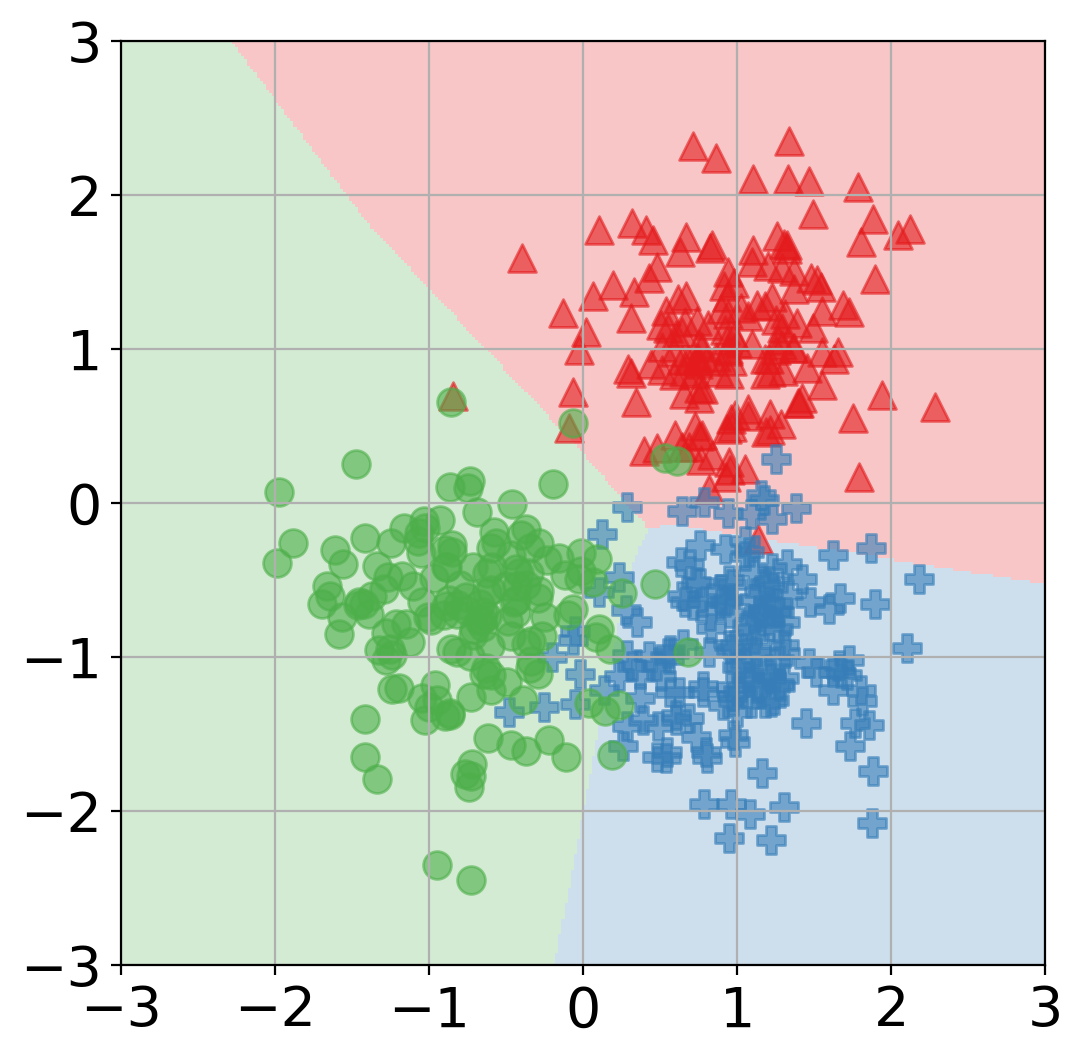

In [14]:
y_lst = []
for x, y in zip(data_4[::interval, :], laybel_4[::interval]):
    indices = torch.topk(model_4(x), k=2).indices
    if indices[0] == y:
        y_lst.append(indices[1].item())
    else:
        y_lst.append(indices[0].item())

y_lst = np.array(y_lst)

step = .02
T = 1 #softmax temperature
x1_min, x1_max = -3, 3 
x2_min, x2_max = -3, 3
x1_range, x2_range = np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step)
xx1, xx2 = np.meshgrid(x1_range, x2_range) # # (500, 400) for both, i.e (x2,x1) as (height,width) as wanted
xx1e, xx2e = np.expand_dims(xx1, -1), np.expand_dims(xx2, -1) # (500, 400, 1) for both
xx = np.concatenate([xx1e, xx2e], axis=-1) ## (500, 400, 2)

xxflat = xx.reshape((-1, 2)) #(200000, 2)
Y_teacher = torch.softmax(model_sf(torch.from_numpy(xxflat).float())/T, dim=1).detach().numpy() #(200000, 3)
image_teacher = Y_teacher.reshape(x2_range.shape[0], x1_range.shape[0], -1) #(500, 400, 3)

class_preds = np.argmax(Y_teacher, axis=1)
colors = np.array([list(set1_cmap.colors[c]) for c in class_preds])
image_teacher = colors.reshape(x2_range.shape[0], x1_range.shape[0], 3)


fig, ax = plt.subplots(figsize=(6,6), dpi=200)
interval=5

ax.imshow(image_teacher, extent=[x1_min, x1_max, x2_min, x2_max], alpha=0.25, origin='lower')

x_lst_indice = np.array(len(x_lst))

ax.scatter(data_1[::interval, 0], data_1[::interval, 1], alpha=0.6, color=set1_cmap.colors[0], marker='^', s=100)
ax.scatter(data_2[::interval, 0], data_2[::interval, 1], alpha=0.6, color=set1_cmap.colors[1], marker='P', s=100)
ax.scatter(data_3[::interval, 0], data_3[::interval, 1], alpha=0.6, color=set1_cmap.colors[2], marker='o', s=100)

ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

ax.grid(True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
